# 1. Import and Install Dependencies

In [1]:
#!pip install opencv-python mediapipe sklearn matplotlib

In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [9]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [10]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [11]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [12]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks(frame, results)

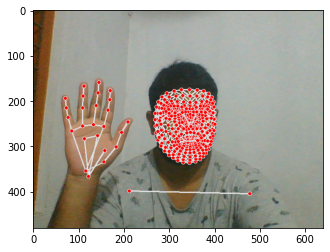

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [10]:
468*3+33*4+21*3+21*3

1662

# 4. Setup Folders for Collection

In [14]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
#actions = np.array(['hello', 'thanks', 'iloveyou', 'yes', 'no'])
actions = np.array(['hello', 'thanks', 'iloveyou', 'like'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 10

In [15]:
# hello
## 0
## 1
## 2
## ...
## 29
# thanks

# I love you

In [15]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [16]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [25]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [17]:
label_map = {label:num for num, label in enumerate(actions)}

In [18]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2, 'like': 3}

In [19]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [20]:
np.array(sequences).shape

(120, 10, 1662)

In [21]:
np.array(labels).shape

(120,)

In [22]:
X = np.array(sequences)

In [23]:
X.shape

(120, 10, 1662)

In [24]:
y = to_categorical(labels).astype(int)

In [25]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1,

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [27]:
X_train.shape

(114, 10, 1662)

# 7. Build and Train LSTM Neural Network

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [30]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [37]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-tr

In [39]:
res = [.7, 0.2, 0.1]

In [40]:
actions[np.argmax(res)]

'hello'

In [41]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [42]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
4/4 [==============================] - 3s 34ms/step - loss: 1.4018 - categorical_accuracy: 0.2193
Epoch 2/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.3929 - categorical_accuracy: 0.2368
Epoch 3/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.3965 - categorical_accuracy: 0.2807
Epoch 4/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.3856 - categorical_accuracy: 0.2544
Epoch 5/1000
4/4 [==============================] - 0s 34ms/step - loss: 1.3814 - categorical_accuracy: 0.3158
Epoch 6/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.3519 - categorical_accuracy: 0.2456
Epoch 7/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.2791 - categorical_accuracy: 0.3684
Epoch 8/1000
4/4 [==============================] - 0s 36ms/step - loss: 1.2789 - categorical_accuracy: 0.3772
Epoch 9/1000
4/4 [==============================] - 0s 34ms/step - loss: 1.2132 - categorical_accuracy: 0.3421
E

4/4 [==============================] - 0s 36ms/step - loss: 0.9090 - categorical_accuracy: 0.6228
Epoch 75/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.8411 - categorical_accuracy: 0.8158
Epoch 76/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.7707 - categorical_accuracy: 0.7807
Epoch 77/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.6701 - categorical_accuracy: 0.8421
Epoch 78/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.5814 - categorical_accuracy: 0.8684
Epoch 79/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.5034 - categorical_accuracy: 0.8860
Epoch 80/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.2711 - categorical_accuracy: 0.8860
Epoch 81/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.2616 - categorical_accuracy: 0.8860
Epoch 82/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.2367 - categorical_accuracy: 0.8947
Epoch 

4/4 [==============================] - 0s 39ms/step - loss: 0.3354 - categorical_accuracy: 0.8509
Epoch 147/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.3632 - categorical_accuracy: 0.8333
Epoch 148/1000
4/4 [==============================] - 0s 63ms/step - loss: 0.3282 - categorical_accuracy: 0.8246
Epoch 149/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.2289 - categorical_accuracy: 0.8860
Epoch 150/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.1579 - categorical_accuracy: 0.9386
Epoch 151/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.1377 - categorical_accuracy: 0.9737
Epoch 152/1000
4/4 [==============================] - 0s 49ms/step - loss: 0.1218 - categorical_accuracy: 0.9561
Epoch 153/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0827 - categorical_accuracy: 0.9912
Epoch 154/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0759 - categorical_accuracy: 0.973

4/4 [==============================] - 0s 36ms/step - loss: 0.2270 - categorical_accuracy: 0.8772
Epoch 219/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.2074 - categorical_accuracy: 0.9123
Epoch 220/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.1697 - categorical_accuracy: 0.9298
Epoch 221/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.1079 - categorical_accuracy: 0.9825
Epoch 222/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.1003 - categorical_accuracy: 0.9737
Epoch 223/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0922 - categorical_accuracy: 0.9649
Epoch 224/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0682 - categorical_accuracy: 0.9912
Epoch 225/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0397 - categorical_accuracy: 1.0000
Epoch 226/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0330 - categorical_accuracy: 1.000

4/4 [==============================] - 0s 41ms/step - loss: 1.8583e-05 - categorical_accuracy: 1.0000
Epoch 290/1000
4/4 [==============================] - 0s 42ms/step - loss: 1.8060e-05 - categorical_accuracy: 1.0000
Epoch 291/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.7703e-05 - categorical_accuracy: 1.0000
Epoch 292/1000
4/4 [==============================] - 0s 42ms/step - loss: 1.7250e-05 - categorical_accuracy: 1.0000
Epoch 293/1000
4/4 [==============================] - 0s 41ms/step - loss: 1.6777e-05 - categorical_accuracy: 1.0000
Epoch 294/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.6376e-05 - categorical_accuracy: 1.0000
Epoch 295/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.5838e-05 - categorical_accuracy: 1.0000
Epoch 296/1000
4/4 [==============================] - 0s 36ms/step - loss: 1.5515e-05 - categorical_accuracy: 1.0000
Epoch 297/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.51

4/4 [==============================] - 0s 36ms/step - loss: 5.8138e-06 - categorical_accuracy: 1.0000
Epoch 360/1000
4/4 [==============================] - 0s 39ms/step - loss: 5.7238e-06 - categorical_accuracy: 1.0000
Epoch 361/1000
4/4 [==============================] - 0s 36ms/step - loss: 5.6496e-06 - categorical_accuracy: 1.0000
Epoch 362/1000
4/4 [==============================] - 0s 36ms/step - loss: 5.5848e-06 - categorical_accuracy: 1.0000
Epoch 363/1000
4/4 [==============================] - 0s 36ms/step - loss: 5.5147e-06 - categorical_accuracy: 1.0000
Epoch 364/1000
4/4 [==============================] - 0s 37ms/step - loss: 5.4583e-06 - categorical_accuracy: 1.0000
Epoch 365/1000
4/4 [==============================] - 0s 35ms/step - loss: 5.3809e-06 - categorical_accuracy: 1.0000
Epoch 366/1000
4/4 [==============================] - 0s 36ms/step - loss: 5.3317e-06 - categorical_accuracy: 1.0000
Epoch 367/1000
4/4 [==============================] - 0s 38ms/step - loss: 5.24

4/4 [==============================] - 0s 40ms/step - loss: 2.5148e-06 - categorical_accuracy: 1.0000
Epoch 430/1000
4/4 [==============================] - 0s 39ms/step - loss: 2.4887e-06 - categorical_accuracy: 1.0000
Epoch 431/1000
4/4 [==============================] - 0s 44ms/step - loss: 2.4688e-06 - categorical_accuracy: 1.0000
Epoch 432/1000
4/4 [==============================] - 0s 40ms/step - loss: 2.4427e-06 - categorical_accuracy: 1.0000
Epoch 433/1000
4/4 [==============================] - 0s 38ms/step - loss: 2.4113e-06 - categorical_accuracy: 1.0000
Epoch 434/1000
4/4 [==============================] - 0s 38ms/step - loss: 2.4040e-06 - categorical_accuracy: 1.0000
Epoch 435/1000
4/4 [==============================] - 0s 41ms/step - loss: 2.3716e-06 - categorical_accuracy: 1.0000
Epoch 436/1000
4/4 [==============================] - 0s 39ms/step - loss: 2.3517e-06 - categorical_accuracy: 1.0000
Epoch 437/1000
4/4 [==============================] - 0s 40ms/step - loss: 2.33

4/4 [==============================] - 0s 41ms/step - loss: 1.4044e-06 - categorical_accuracy: 1.0000
Epoch 500/1000
4/4 [==============================] - 0s 77ms/step - loss: 1.3960e-06 - categorical_accuracy: 1.0000
Epoch 501/1000
4/4 [==============================] - 0s 56ms/step - loss: 1.3834e-06 - categorical_accuracy: 1.0000
Epoch 502/1000
4/4 [==============================] - 0s 43ms/step - loss: 1.3761e-06 - categorical_accuracy: 1.0000
Epoch 503/1000
4/4 [==============================] - 0s 52ms/step - loss: 1.3646e-06 - categorical_accuracy: 1.0000
Epoch 504/1000
4/4 [==============================] - 0s 42ms/step - loss: 1.3594e-06 - categorical_accuracy: 1.0000
Epoch 505/1000
4/4 [==============================] - 0s 61ms/step - loss: 1.3489e-06 - categorical_accuracy: 1.0000
Epoch 506/1000
4/4 [==============================] - 0s 93ms/step - loss: 1.3416e-06 - categorical_accuracy: 1.0000
Epoch 507/1000
4/4 [==============================] - 0s 60ms/step - loss: 1.33

4/4 [==============================] - 0s 38ms/step - loss: 8.7838e-07 - categorical_accuracy: 1.0000
Epoch 570/1000
4/4 [==============================] - 0s 39ms/step - loss: 8.7315e-07 - categorical_accuracy: 1.0000
Epoch 571/1000
4/4 [==============================] - 0s 36ms/step - loss: 8.6897e-07 - categorical_accuracy: 1.0000
Epoch 572/1000
4/4 [==============================] - 0s 35ms/step - loss: 8.6269e-07 - categorical_accuracy: 1.0000
Epoch 573/1000
4/4 [==============================] - 0s 36ms/step - loss: 8.5746e-07 - categorical_accuracy: 1.0000
Epoch 574/1000
4/4 [==============================] - 0s 38ms/step - loss: 8.5224e-07 - categorical_accuracy: 1.0000
Epoch 575/1000
4/4 [==============================] - 0s 40ms/step - loss: 8.4805e-07 - categorical_accuracy: 1.0000
Epoch 576/1000
4/4 [==============================] - 0s 48ms/step - loss: 8.4282e-07 - categorical_accuracy: 1.0000
Epoch 577/1000
4/4 [==============================] - 0s 36ms/step - loss: 8.37

4/4 [==============================] - 0s 31ms/step - loss: 5.8768e-07 - categorical_accuracy: 1.0000
Epoch 640/1000
4/4 [==============================] - 0s 34ms/step - loss: 5.8350e-07 - categorical_accuracy: 1.0000
Epoch 641/1000
4/4 [==============================] - 0s 32ms/step - loss: 5.8245e-07 - categorical_accuracy: 1.0000
Epoch 642/1000
4/4 [==============================] - 0s 33ms/step - loss: 5.7827e-07 - categorical_accuracy: 1.0000
Epoch 643/1000
4/4 [==============================] - 0s 36ms/step - loss: 5.7408e-07 - categorical_accuracy: 1.0000
Epoch 644/1000
4/4 [==============================] - 0s 36ms/step - loss: 5.6990e-07 - categorical_accuracy: 1.0000
Epoch 645/1000
4/4 [==============================] - 0s 35ms/step - loss: 5.6676e-07 - categorical_accuracy: 1.0000
Epoch 646/1000
4/4 [==============================] - 0s 39ms/step - loss: 5.6363e-07 - categorical_accuracy: 1.0000
Epoch 647/1000
4/4 [==============================] - 0s 37ms/step - loss: 5.60

4/4 [==============================] - 0s 40ms/step - loss: 4.0782e-07 - categorical_accuracy: 1.0000
Epoch 710/1000
4/4 [==============================] - 0s 32ms/step - loss: 4.0468e-07 - categorical_accuracy: 1.0000
Epoch 711/1000
4/4 [==============================] - 0s 35ms/step - loss: 4.0364e-07 - categorical_accuracy: 1.0000
Epoch 712/1000
4/4 [==============================] - 0s 34ms/step - loss: 4.0050e-07 - categorical_accuracy: 1.0000
Epoch 713/1000
4/4 [==============================] - 0s 38ms/step - loss: 3.9736e-07 - categorical_accuracy: 1.0000
Epoch 714/1000
4/4 [==============================] - 0s 34ms/step - loss: 3.9632e-07 - categorical_accuracy: 1.0000
Epoch 715/1000
4/4 [==============================] - 0s 36ms/step - loss: 3.9318e-07 - categorical_accuracy: 1.0000
Epoch 716/1000
4/4 [==============================] - 0s 35ms/step - loss: 3.9318e-07 - categorical_accuracy: 1.0000
Epoch 717/1000
4/4 [==============================] - 0s 33ms/step - loss: 3.91

4/4 [==============================] - 0s 37ms/step - loss: 2.9489e-07 - categorical_accuracy: 1.0000
Epoch 780/1000
4/4 [==============================] - 0s 36ms/step - loss: 2.9279e-07 - categorical_accuracy: 1.0000
Epoch 781/1000
4/4 [==============================] - 0s 36ms/step - loss: 2.9279e-07 - categorical_accuracy: 1.0000
Epoch 782/1000
4/4 [==============================] - 0s 35ms/step - loss: 2.9070e-07 - categorical_accuracy: 1.0000
Epoch 783/1000
4/4 [==============================] - 0s 37ms/step - loss: 2.8966e-07 - categorical_accuracy: 1.0000
Epoch 784/1000
4/4 [==============================] - 0s 43ms/step - loss: 2.8861e-07 - categorical_accuracy: 1.0000
Epoch 785/1000
4/4 [==============================] - 0s 37ms/step - loss: 2.8861e-07 - categorical_accuracy: 1.0000
Epoch 786/1000
4/4 [==============================] - 0s 39ms/step - loss: 2.8861e-07 - categorical_accuracy: 1.0000
Epoch 787/1000
4/4 [==============================] - 0s 36ms/step - loss: 2.84

4/4 [==============================] - 0s 45ms/step - loss: 2.1750e-07 - categorical_accuracy: 1.0000
Epoch 850/1000
4/4 [==============================] - 0s 38ms/step - loss: 2.1750e-07 - categorical_accuracy: 1.0000
Epoch 851/1000
4/4 [==============================] - 0s 38ms/step - loss: 2.1646e-07 - categorical_accuracy: 1.0000
Epoch 852/1000
4/4 [==============================] - 0s 37ms/step - loss: 2.1646e-07 - categorical_accuracy: 1.0000
Epoch 853/1000
4/4 [==============================] - 0s 39ms/step - loss: 2.1541e-07 - categorical_accuracy: 1.0000
Epoch 854/1000
4/4 [==============================] - 0s 42ms/step - loss: 2.1437e-07 - categorical_accuracy: 1.0000
Epoch 855/1000
4/4 [==============================] - 0s 44ms/step - loss: 2.1437e-07 - categorical_accuracy: 1.0000
Epoch 856/1000
4/4 [==============================] - 0s 43ms/step - loss: 2.1332e-07 - categorical_accuracy: 1.0000
Epoch 857/1000
4/4 [==============================] - 0s 37ms/step - loss: 2.12

4/4 [==============================] - 0s 39ms/step - loss: 1.6417e-07 - categorical_accuracy: 1.0000
Epoch 920/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.6313e-07 - categorical_accuracy: 1.0000
Epoch 921/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.6313e-07 - categorical_accuracy: 1.0000
Epoch 922/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.6313e-07 - categorical_accuracy: 1.0000
Epoch 923/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.6313e-07 - categorical_accuracy: 1.0000
Epoch 924/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.6313e-07 - categorical_accuracy: 1.0000
Epoch 925/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.6208e-07 - categorical_accuracy: 1.0000
Epoch 926/1000
4/4 [==============================] - 0s 39ms/step - loss: 1.6104e-07 - categorical_accuracy: 1.0000
Epoch 927/1000
4/4 [==============================] - 0s 36ms/step - loss: 1.59

4/4 [==============================] - 0s 32ms/step - loss: 1.2444e-07 - categorical_accuracy: 1.0000
Epoch 990/1000
4/4 [==============================] - 0s 36ms/step - loss: 1.2444e-07 - categorical_accuracy: 1.0000
Epoch 991/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.2444e-07 - categorical_accuracy: 1.0000
Epoch 992/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.2339e-07 - categorical_accuracy: 1.0000
Epoch 993/1000
4/4 [==============================] - 0s 31ms/step - loss: 1.2339e-07 - categorical_accuracy: 1.0000
Epoch 994/1000
4/4 [==============================] - 0s 33ms/step - loss: 1.2339e-07 - categorical_accuracy: 1.0000
Epoch 995/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.2235e-07 - categorical_accuracy: 1.0000
Epoch 996/1000
4/4 [==============================] - 0s 32ms/step - loss: 1.2130e-07 - categorical_accuracy: 1.0000
Epoch 997/1000
4/4 [==============================] - 0s 33ms/step - loss: 1.20

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-tr

# 8. Make Predictions

In [49]:
X_test.shape

(6, 10, 1662)

In [44]:
res = model.predict(X_test)

In [50]:
actions[np.argmax(res[1])]

'iloveyou'

In [51]:
actions[np.argmax(y_test[1])]

'iloveyou'

# 9. Save Weights

In [52]:
model.save('night_actions.h5')

In [99]:
del model

In [1]:
from tensorflow.keras.models import load_model

In [2]:
model = load_model('night_actions.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-tr

# 10. Evaluation using Confusion Matrix and Accuracy

In [3]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [28]:
yhat = model.predict(X_test)

In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [30]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[5, 0],
        [0, 1]],

       [[3, 0],
        [0, 3]],

       [[4, 0],
        [0, 2]]], dtype=int64)

In [31]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [32]:
colors = [(245,117,16), (117,245,16), (16,117,245), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [33]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'image' is not defined

<Figure size 1296x1296 with 0 Axes>

In [34]:
sequence.reverse()

AttributeError: 'int' object has no attribute 'reverse'

In [23]:
len(sequence)

1

In [51]:
sequence.append('def')

In [34]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [38]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-10:]
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutput

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class '

like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<cl

like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<cl

like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<class 'mediapipe.python.solution_base.SolutionOutputs'>
like
<cl

In [20]:
cap.release()
cv2.destroyAllWindows()

In [247]:
res[np.argmax(res)] > threshold

True

In [ ]:
(num_sequences,30,1662)

In [240]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[5.532469e-04, 9.974770e-01, 1.969744e-03]], dtype=float32)